# Big Mountain Resort Guided Capstone Project Report <a id='4_Pre-Processing_and_Training_Data'></a>

## Table of Contents 
* [Problem Statement] <a id='Problem Statement'></a>
  * [Imports](Imports)

## 1. Problem Statement <a id='Problem Statement'></a>

The Big Mountain Resort charges a premium above the average price of resorts in its market segment but doesn’t know how to prioritize operation of its services (e.g. runs, chair lifts, snow making machines). A data-driven business strategy will help us adjust our current pricing of $81 for a weekday or weekend ticket to make sure we are in line with our competitors. Currently, our strategy is to charge an above the average competitor resort price but this doesn’t allow us to prioritize feature investment and maximize our revenue. This analysis was carried out to see how a data science algorithm might help us figure out what drives ticket prices in our market share and also evaluate potential feature investment modifications based on how they will affect what we can charge customers. 


### Imports <a id='Imports'></a>

In [309]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from library.sb_utils import save_file

# 2. Data Wrangling <a id='Data_Wrangling'></a>

## View data

In [312]:
# The CSV data file supplied by Database Manager 
ski_data = pd.read_csv('../raw_data/ski_resort_data.csv')
ski_data.head()


,Name,Region,state,summit_elev,vertical_drop,base_elev,trams,fastEight,fastSixes,fastQuads,...,LongestRun_mi,SkiableTerrain_ac,Snow Making_ac,daysOpenLastYear,yearsOpen,averageSnowfall,AdultWeekday,AdultWeekend,projectedDaysOpen,NightSkiing_ac
0,Alyeska Resort,Alaska,Alaska,3939,2500,250,1,0.0,0,2,...,1.0,1610.0,113.0,150.0,60.0,669.0,65.0,85.0,150.0,550.0
1,Eaglecrest Ski Area,Alaska,Alaska,2600,1540,1200,0,0.0,0,0,...,2.0,640.0,60.0,45.0,44.0,350.0,47.0,53.0,90.0,NaN
2,Hilltop Ski Area,Alaska,Alaska,2090,294,1796,0,0.0,0,0,...,1.0,30.0,30.0,150.0,36.0,69.0,30.0,34.0,152.0,30.0
3,Arizona Snowbowl,Arizona,Arizona,11500,2300,9200,0,0.0,1,0,...,2.0,777.0,104.0,122.0,81.0,260.0,89.0,89.0,122.0,NaN
4,Sunrise Park Resort,Arizona,Arizona,11100,1800,9200,0,NaN,0,1,...,1.2,800.0,80.0,115.0,49.0,250.0,74.0,78.0,104.0,80.0


In [313]:
ski_data.head().T

,0,1,2,3,4
Name,Alyeska Resort,Eaglecrest Ski Area,Hilltop Ski Area,Arizona Snowbowl,Sunrise Park Resort
Region,Alaska,Alaska,Alaska,Arizona,Arizona
state,Alaska,Alaska,Alaska,Arizona,Arizona
summit_elev,3939,2600,2090,11500,11100
vertical_drop,2500,1540,294,2300,1800
base_elev,250,1200,1796,9200,9200
trams,1,0,0,0,0
fastEight,0.0,0.0,0.0,0.0,NaN
fastSixes,0,0,0,1,0
fastQuads,2,0,0,0,1


In [314]:
# View characteristics of the Big Mountain Ski Resort
ski_data[ski_data.Name == 'Big Mountain Resort'].T

,151
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastEight,0.0
fastSixes,0
fastQuads,3


## Check for missing data

In [316]:
# Examine missing data by counting the number of missing values in each column of 
#ski_data and the percentages in decreasing order 
missing = pd.concat([ski_data.isnull().sum(), 100 * ski_data.isnull().mean()], axis=1)
missing.columns = ['count', '%']
missing.sort_values('%', ascending = False)

,count,%
fastEight,166,50.303030
NightSkiing_ac,143,43.333333
AdultWeekday,54,16.363636
AdultWeekend,51,15.454545
daysOpenLastYear,51,15.454545
TerrainParks,51,15.454545
projectedDaysOpen,47,14.242424
Snow Making_ac,46,13.939394
averageSnowfall,14,4.242424
LongestRun_mi,5,1.515152


In [318]:
missing_price = ski_data[['AdultWeekend', 'AdultWeekday']].isnull().sum(axis=1)
missing_price.value_counts()/len(missing_price) * 100


0    82.424242
2    14.242424
1     3.333333
Name: count, dtype: float64

In [319]:
print(missing_price.value_counts())

0    272
2     47
1     11
Name: count, dtype: int64


In [320]:
# 47 resorts are missing both prices, view their resort names
mask2 = missing_price==2
print(type(missing_price))
print(ski_data.loc[mask2, ['Name','AdultWeekend','AdultWeekday']]) 

<class 'pandas.core.series.Series'>
                              Name  AdultWeekend  AdultWeekday
6                    Bear Mountain           NaN           NaN
7                      Bear Valley           NaN           NaN
11        Heavenly Mountain Resort           NaN           NaN
12                   June Mountain           NaN           NaN
13                        Kirkwood           NaN           NaN
18            Northstar California           NaN           NaN
21                     Snow Summit           NaN           NaN
28                    Beaver Creek           NaN           NaN
29                    Breckenridge           NaN           NaN
31   Crested Butte Mountain Resort           NaN           NaN
33          Eldora Mountain Resort           NaN           NaN
35                        Keystone           NaN           NaN
42                       Steamboat           NaN           NaN
45                            Vail           NaN           NaN
46              Win

In [321]:
# Drop the resorts that are missing both weekend and weekday prices
ski_data = ski_data[missing_price != 2]
# check
missing_price2 = ski_data[['AdultWeekend', 'AdultWeekday']].isnull().sum(axis=1)
print(missing_price2.value_counts())

0    272
1     11
Name: count, dtype: int64


### Check for duplicate records

In [323]:
# Check for duplicate resort records and examine any suspect records
print((ski_data['Name'] + ', ' + ski_data['state']).value_counts().head())
print((ski_data['Name'] + ', ' + ski_data['Region']).value_counts().head())
print(ski_data['Name'].value_counts().head())
ski_data[ski_data['Name'] == 'Crystal Mountain']

Alyeska Resort, Alaska                   1
Willard Mountain, New York               1
Beech Mountain Resort, North Carolina    1
Sapphire Valley, North Carolina          1
Cataloochee Ski Area, North Carolina     1
Name: count, dtype: int64
Alyeska Resort, Alaska                   1
Willard Mountain, New York               1
Beech Mountain Resort, North Carolina    1
Sapphire Valley, North Carolina          1
Cataloochee Ski Area, North Carolina     1
Name: count, dtype: int64
Name
Crystal Mountain         2
Alyeska Resort           1
Wolf Ridge Ski Resort    1
Beech Mountain Resort    1
Sapphire Valley          1
Name: count, dtype: int64


,Name,Region,state,summit_elev,vertical_drop,base_elev,trams,fastEight,fastSixes,fastQuads,...,LongestRun_mi,SkiableTerrain_ac,Snow Making_ac,daysOpenLastYear,yearsOpen,averageSnowfall,AdultWeekday,AdultWeekend,projectedDaysOpen,NightSkiing_ac
104,Crystal Mountain,Michigan,Michigan,1132,375,757,0,0.0,0,1,...,0.3,102.0,96.0,120.0,63.0,132.0,54.0,64.0,135.0,56.0
295,Crystal Mountain,Washington,Washington,7012,3100,4400,1,NaN,2,2,...,2.5,2600.0,10.0,NaN,57.0,486.0,99.0,99.0,NaN,NaN


There are two resorts with the same name in two different states. Both can be left in the data set

## Check to ensure the region and state variables correspond correctly

In [326]:
# Cross-check the state and region values, fix any discrepancies
print((ski_data.Region == ski_data.state).value_counts().head())
ski_data['Region'].value_counts() # count frequencies of each region value

True     260
False     23
Name: count, dtype: int64


Region
New York               33
Michigan               26
Pennsylvania           17
Wisconsin              15
Sierra Nevada          15
New Hampshire          14
Colorado               14
Minnesota              14
Montana                11
Massachusetts          10
Vermont                10
Idaho                  10
New Mexico              9
Maine                   8
Washington              7
Utah                    7
North Carolina          6
Wyoming                 6
Salt Lake City          5
Connecticut             5
Ohio                    5
Oregon                  5
West Virginia           4
Alaska                  3
Illinois                3
Iowa                    3
Virginia                2
Indiana                 2
Arizona                 2
Mt. Hood                2
Missouri                2
Nevada                  2
South Dakota            2
Tennessee               1
New Jersey              1
Maryland                1
Northern California     1
Name: count, dtype: int64

In [327]:
(ski_data[ski_data.Region != ski_data.state]
 .groupby('state')['Region']
 .value_counts())

state       Region             
California  Sierra Nevada          13
            Northern California     1
Nevada      Sierra Nevada           2
Oregon      Mt. Hood                2
Utah        Salt Lake City          5
Name: count, dtype: int64

In [328]:
print(ski_data[['Region','state']].nunique())

Region    37
state     34
dtype: int64


## Examine the distribution Of Ticket Price By state

In [330]:
state_price_means = ski_data.groupby('state')[['AdultWeekday', 'AdultWeekend']].mean()
state_price_means.head()

,AdultWeekday,AdultWeekend
state,,
Alaska,47.333333,57.333333
Arizona,81.500000,83.500000
California,78.214286,81.416667
Colorado,90.714286,90.714286
Connecticut,47.800000,56.800000


In [331]:
print(state_price_means.reindex(index=state_price_means.mean(axis=1)
    .sort_values(ascending=False)
    .index))

                AdultWeekday  AdultWeekend
state                                     
Utah               89.083333     93.000000
Colorado           90.714286     90.714286
Vermont            83.500000     87.900000
Arizona            81.500000     83.500000
New Jersey         79.990000     79.990000
California         78.214286     81.416667
Nevada             78.500000     81.000000
West Virginia      62.500000     79.750000
New Hampshire      65.571429     76.500000
Maryland           59.000000     79.000000
Washington         65.107143     70.144286
New Mexico         65.666667     65.666667
Virginia           51.000000     68.000000
Oregon             58.857143     59.857143
Pennsylvania       52.705882     63.687500
Wyoming            57.600000     56.166667
Maine              51.500000     61.000000
Idaho              56.555556     55.900000
New York           50.032258     58.945455
North Carolina     41.833333     64.166667
Alaska             47.333333     57.333333
Connecticut

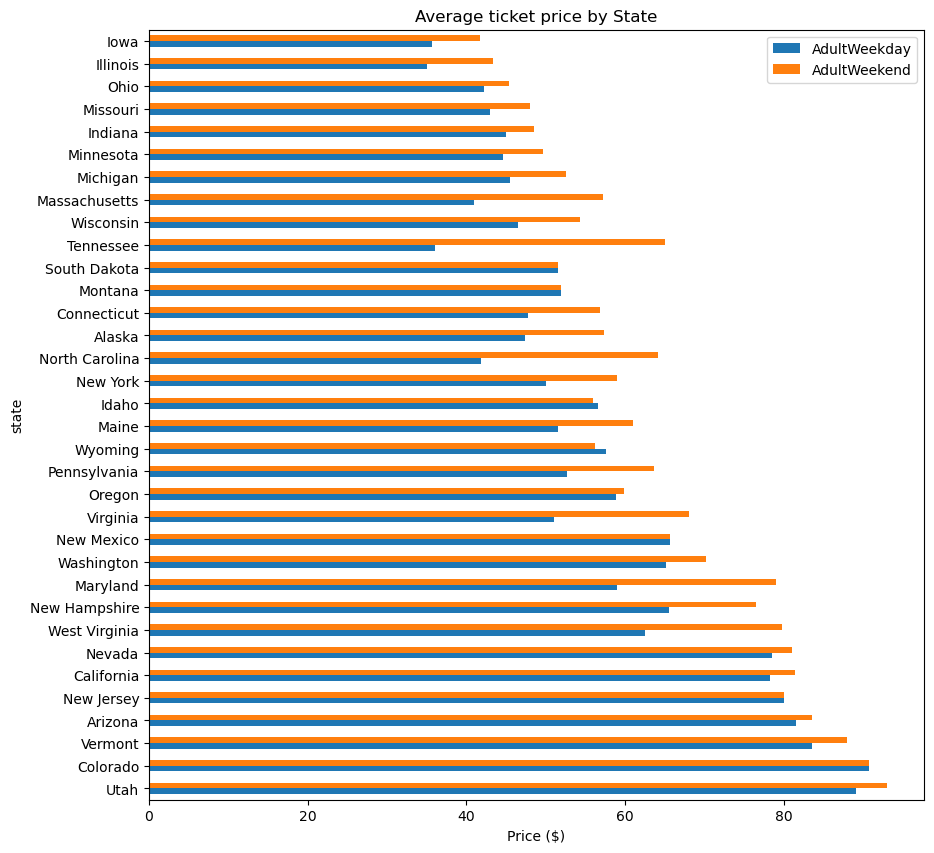

In [332]:
(state_price_means.reindex(index=state_price_means.mean(axis=1)
    .sort_values(ascending=False)
    .index)
    .plot(kind='barh', figsize=(10, 10), title='Average ticket price by State'))
plt.xlabel('Price ($)');

In [333]:
ticket_prices = pd.melt(ski_data[['state','AdultWeekday', 'AdultWeekend']], 
                        id_vars='state', 
                        var_name='Ticket', 
                        value_vars=['AdultWeekday', 'AdultWeekend'], 
                        value_name='Price')

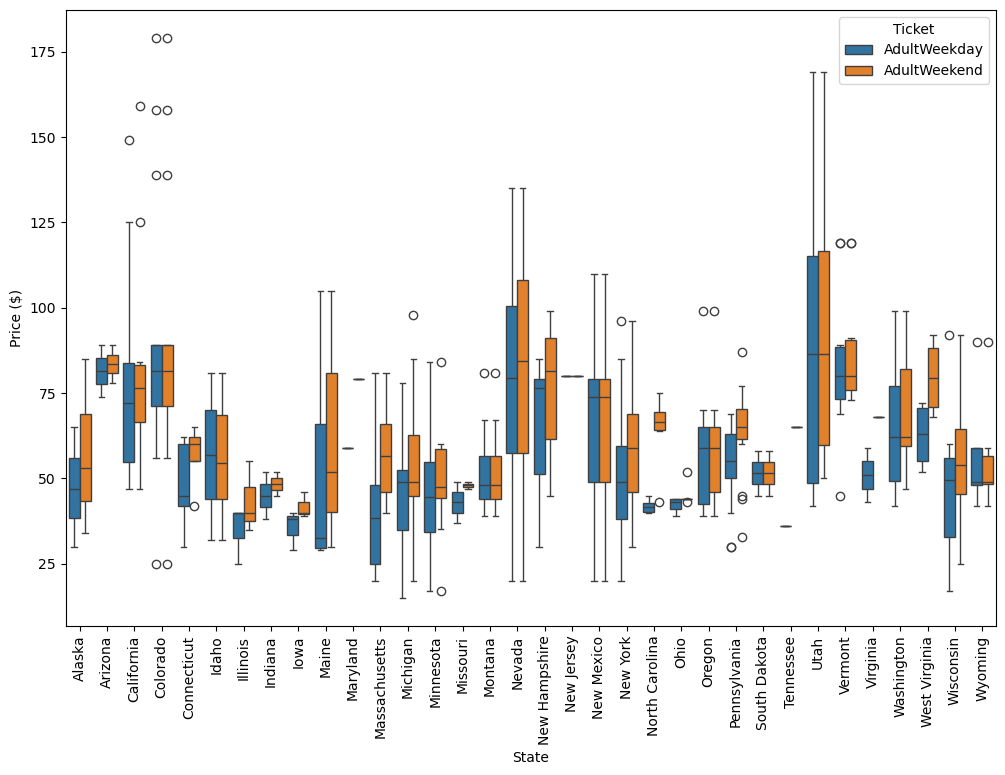

In [334]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='state', y='Price', hue='Ticket', data=ticket_prices)
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)')
plt.xlabel('State');

## Examine numerical data, modify data as needed

In [336]:
ski_data.describe().T


,count,mean,std,min,25%,50%,75%,max
summit_elev,283.0,4305.939929,3590.559812,440.0,1387.50,2400.0,7340.0,13487.0
vertical_drop,283.0,1101.441696,841.193276,60.0,445.00,825.0,1600.0,4425.0
base_elev,283.0,3192.890459,3056.615778,100.0,862.50,1360.0,5870.0,10800.0
trams,283.0,0.109541,0.435988,0.0,0.00,0.0,0.0,3.0
fastEight,135.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
fastSixes,283.0,0.098940,0.372978,0.0,0.00,0.0,0.0,2.0
fastQuads,283.0,0.720848,1.726870,0.0,0.00,0.0,1.0,15.0
quad,283.0,0.936396,1.300375,0.0,0.00,0.0,1.5,8.0
triple,283.0,1.438163,1.557034,0.0,0.00,1.0,2.0,8.0
double,283.0,1.780919,1.835830,0.0,0.00,1.0,2.5,14.0


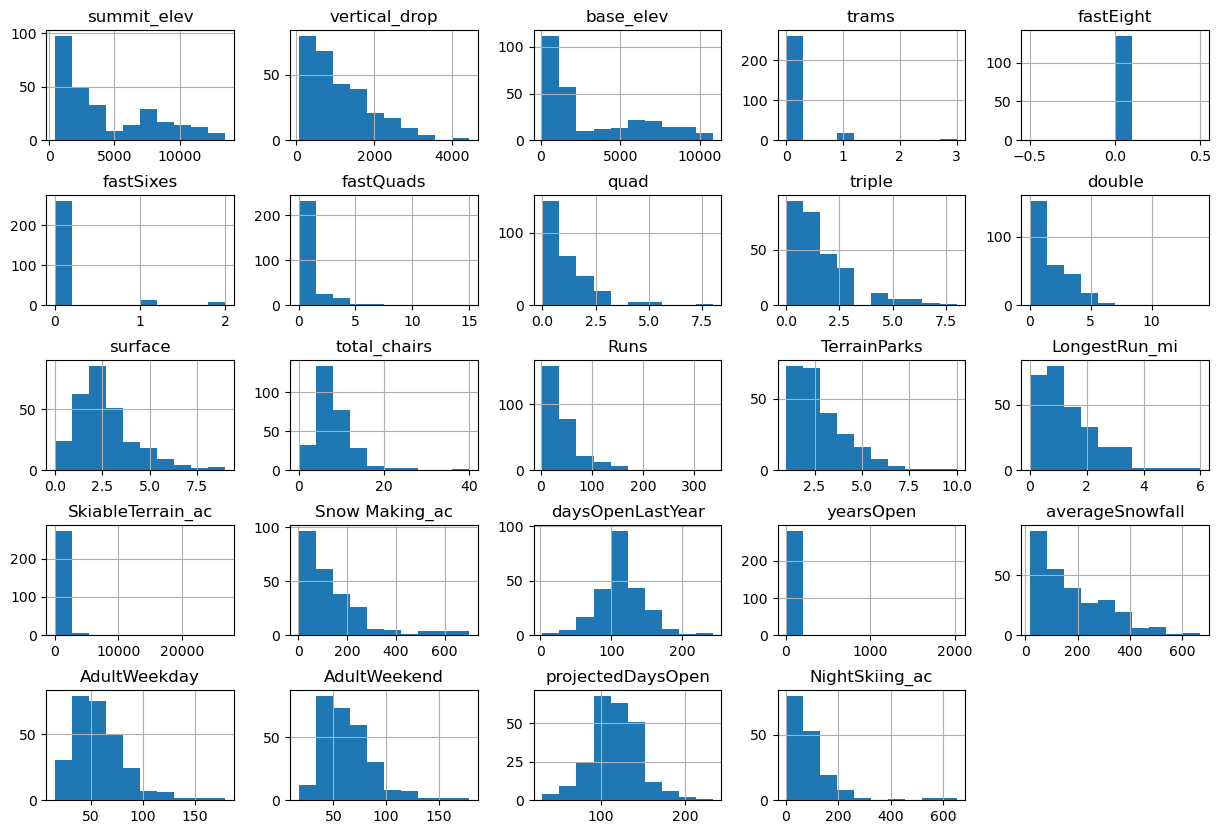

In [337]:
# Examine correlations between numerical variables
ski_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

In [338]:
# Take a closer look at outliers starting with the Skiable Terrain ac variable which is strongly skewed... 
print(ski_data.SkiableTerrain_ac[ski_data.SkiableTerrain_ac >= 5000])


27      5517.0
39     26819.0
267     8464.0
Name: SkiableTerrain_ac, dtype: float64


In [339]:
ski_data[ski_data['SkiableTerrain_ac'] > 5000].T 

,27,39,267
Name,Aspen / Snowmass,Silverton Mountain,Powder Mountain
Region,Colorado,Colorado,Utah
state,Colorado,Colorado,Utah
summit_elev,12510,13487,9422
vertical_drop,4406,3087,2522
base_elev,8104,10400,6900
trams,3,0,0
fastEight,0.0,0.0,0.0
fastSixes,1,0,0
fastQuads,15,0,1


In [340]:
ski_data.loc[39, 'SkiableTerrain_ac']

26819.0

In [341]:
# Modify incorrect value for Silverton Mountain based on a [quick web search](https://en.wikipedia.org/wiki/Silverton_Mountain)
ski_data.loc[39, 'SkiableTerrain_ac'] = 1819
ski_data.loc[39, 'SkiableTerrain_ac']

1819.0

fastEight
0.0    135
Name: count, dtype: int64


<Axes: >

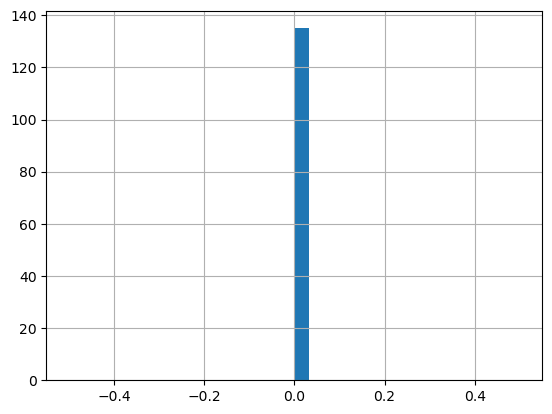

In [375]:
## Take a closer look at the fastEight variable seems to have almost no variation 
print(ski_data.fastEight.value_counts())
ski_data.fastEight[ski_data.fastEight < 105].hist(bins=30)

In [381]:
# All the values of fastEight are zero, doesn't given any useful information so drop this feature
ski_data.drop(columns='fastEight', inplace=True)
ski_data.columns

Index(['Name', 'Region', 'state', 'summit_elev', 'vertical_drop', 'base_elev',
       'trams', 'fastSixes', 'fastQuads', 'quad', 'triple', 'double',
       'surface', 'total_chairs', 'Runs', 'TerrainParks', 'LongestRun_mi',
       'SkiableTerrain_ac', 'Snow Making_ac', 'daysOpenLastYear', 'yearsOpen',
       'averageSnowfall', 'AdultWeekday', 'AdultWeekend', 'projectedDaysOpen',
       'NightSkiing_ac'],
      dtype='object')

## Take a closer look at the years open variable

34      104.0
115    2019.0
Name: yearsOpen, dtype: float64


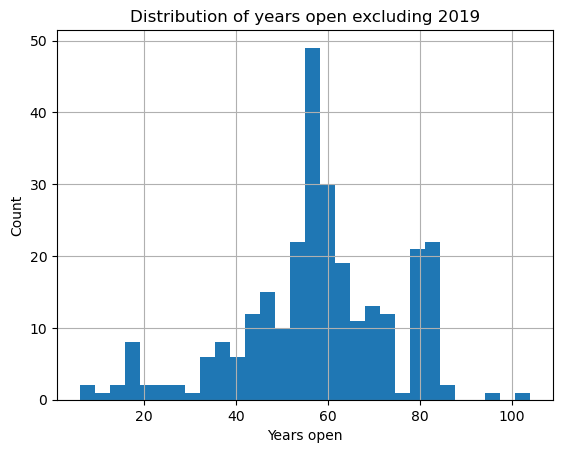

In [383]:
print(ski_data.yearsOpen[ski_data.yearsOpen > 100])
ski_data.yearsOpen[ski_data.yearsOpen < 105].hist(bins=30)
plt.xlabel('Years open')
plt.ylabel('Count')
plt.title('Distribution of years open excluding 2019');

In [385]:
# Modify the data set by dropping the resort opened 2019 years ago since this is not possible, likely a data entry error
ski_data.yearsOpen[ski_data.yearsOpen < 1000].describe()

count    281.000000
mean      57.811388
std       17.049613
min        6.000000
25%       50.000000
50%       58.000000
75%       70.000000
max      104.000000
Name: yearsOpen, dtype: float64

## Enrich resort data set with state-wide data characteristics

In [390]:
# create ratios from resort-level data to describe the resorts in each state
state_summary = ski_data.groupby('state').agg(
    resorts_per_state=pd.NamedAgg(column='Name', aggfunc='size'), #could pick any column here
    state_total_skiable_area_ac=pd.NamedAgg(column='SkiableTerrain_ac', aggfunc='sum'),
    state_total_days_open=pd.NamedAgg(column='daysOpenLastYear', aggfunc='sum'),
    state_total_terrainparks=pd.NamedAgg(column='TerrainParks', aggfunc='sum'),
    state_total_nightskiing_ac=pd.NamedAgg(column='NightSkiing_ac', aggfunc='sum')
).reset_index()
state_summary.head()

,state,resorts_per_state,state_total_skiable_area_ac,state_total_days_open,state_total_terrainparks,state_total_nightskiing_ac
0,Alaska,3,2280.0,345.0,4.0,580.0
1,Arizona,2,1577.0,237.0,6.0,80.0
2,California,14,12060.0,1961.0,43.0,437.0
3,Colorado,14,22232.0,2003.0,40.0,110.0
4,Connecticut,5,358.0,353.0,10.0,256.0


In [392]:
# Pull state demographic info from wikipedia
states_url = 'https://simple.wikipedia.org/w/index.php?title=List_of_U.S._states&oldid=7168473'
usa_states = pd.read_html(states_url)

In [394]:
usa_states = usa_states[0]
usa_states.head()

Name & postal abbs. [1]                                 Cities               \
  Name & postal abbs. [1] Name & postal abbs. [1].1      Capital   Largest[5]   
0                 Alabama                        AL   Montgomery   Birmingham   
1                  Alaska                        AK       Juneau    Anchorage   
2                 Arizona                        AZ      Phoenix      Phoenix   
3                Arkansas                        AR  Little Rock  Little Rock   
4              California                        CA   Sacramento  Los Angeles   

  Established[A] Population [B][3] Total area[4]          Land area[4]  \
  Established[A] Population [B][3]           mi2      km2          mi2   
0   Dec 14, 1819           4903185         52420   135767        50645   
1    Jan 3, 1959            731545        665384  1723337       570641   
2   Feb 14, 1912           7278717        113990   295234       113594   
3   Jun 15, 1836           3017804         53179   137732        52035   
4    Sep 9, 1850          39512223        163695   423967       155779   

           Water area[4]         Number of Reps.  
       km2           mi2     km2 Number of Reps.  
0   131171          1775    4597               7  
1  1477953         94743  245384               1  
2   294207           396    1026               9  
3   134771          1143    2961               4  
4   403466          7916   20501              53

In [398]:
# Extract the state name, population, and total area (square miles) columns.
usa_states_sub = usa_states.iloc[:, [0,5,6]].copy()
usa_states_sub.columns = ['state','state_population', 'state_area_sq_miles']
usa_states_sub.head()

,state,state_population,state_area_sq_miles
0,Alabama,4903185,52420
1,Alaska,731545,665384
2,Arizona,7278717,113990
3,Arkansas,3017804,53179
4,California,39512223,163695


In [400]:
# Make sure there is demographic data from wikipedia for each of the states in the ski data set
missing_states = set(state_summary.state) - set(usa_states_sub.state)
missing_states

{'Massachusetts', 'Pennsylvania', 'Virginia'}

In [402]:
usa_states_sub.state[usa_states_sub.state.str.contains('Massachusetts|Pennsylvania|Rhode Island|Virginia')]

20    Massachusetts[C]
37     Pennsylvania[C]
38     Rhode Island[D]
45         Virginia[C]
47       West Virginia
Name: state, dtype: object

In [404]:
# Remove characters after each state name
usa_states_sub.state.replace(to_replace='\[.*\]', value='', regex=True, inplace=True)
usa_states_sub.state[usa_states_sub.state.str.contains('Massachusetts|Pennsylvania|Rhode Island|Virginia')]

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
/var/folders/zg/81kjn_8j4692tlw3f6q33h6w0000gq/T/ipykernel_70946/2909591317.py:1: SyntaxWarning: invalid escape sequence '\['
  usa_states_sub.state.replace(to_replace='\[.*\]', value='', regex=True, inplace=True)


20    Massachusetts
37     Pennsylvania
38     Rhode Island
45         Virginia
47    West Virginia
Name: state, dtype: object

In [406]:
missing_states = set(state_summary.state) - set(usa_states_sub.state)
missing_states

set()

In [408]:
# merge left to enrich ski data with state-level demographic info
state_summary = state_summary.merge(usa_states_sub, how='left', on='state')
state_summary.head()

,state,resorts_per_state,state_total_skiable_area_ac,state_total_days_open,state_total_terrainparks,state_total_nightskiing_ac,state_population,state_area_sq_miles
0,Alaska,3,2280.0,345.0,4.0,580.0,731545,665384
1,Arizona,2,1577.0,237.0,6.0,80.0,7278717,113990
2,California,14,12060.0,1961.0,43.0,437.0,39512223,163695
3,Colorado,14,22232.0,2003.0,40.0,110.0,5758736,104094
4,Connecticut,5,358.0,353.0,10.0,256.0,3565278,5543


## Define the target feature using price data

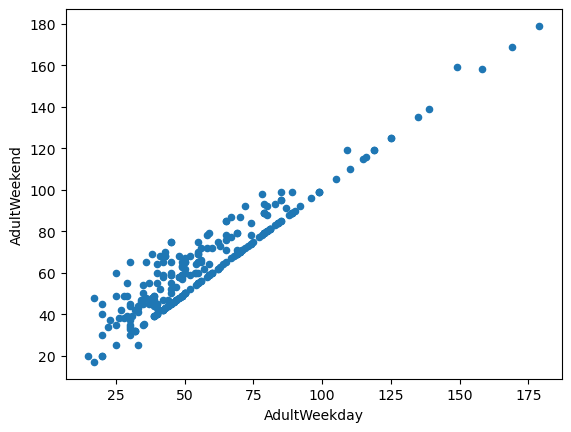

In [410]:
ski_data.plot(x='AdultWeekday', y='AdultWeekend', kind='scatter');

In [412]:
ski_data.loc[ski_data.state == 'Montana', ['Name','AdultWeekend','AdultWeekday']]

,Name,AdultWeekend,AdultWeekday
141,Blacktail Mountain Ski Area,42.0,42.0
142,Bridger Bowl,63.0,63.0
143,Discovery Ski Area,49.0,49.0
144,Great Divide,48.0,48.0
145,Lost Trail - Powder Mtn,46.0,46.0
146,Maverick Mountain,39.0,39.0
147,Montana Snowbowl,50.0,50.0
148,Red Lodge Mountain,67.0,67.0
149,Showdown Montana,47.0,47.0
150,Teton Pass Ski Resort,39.0,39.0


In [414]:
ski_data[['AdultWeekend', 'AdultWeekday']].isnull().sum()

AdultWeekend    4
AdultWeekday    7
dtype: int64

In [ ]:
Weekend and weekday prices are strongly correlated. However, more resorts are missing weekday prices than are missing weekend prices
prices so drop the AdultWeekday price feature

In [426]:
# Remove resort/rows with missing AdultWeekend data
ski_data.drop(columns='AdultWeekday', inplace=True)
# Remove all resorts for which the target feature, weekend ticket price is missing 
ski_data.dropna(subset=['AdultWeekend'], inplace=True)

In [428]:
ski_data.shape

(279, 25)

## Revisit missing data

In [440]:
missing = pd.concat([ski_data.isnull().sum(axis=1), 100 * ski_data.isnull().mean(axis=1)], axis=1)
print(type(missing))
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>


,count,%
329,5,20.0
146,5,20.0
141,5,20.0
62,5,20.0
74,5,20.0
86,5,20.0
186,4,16.0
55,4,16.0
314,4,16.0
198,4,16.0


Leave these records in for now as they may contain useful non-missing data

In [444]:
ski_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 279 entries, 0 to 329
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               279 non-null    object 
 1   Region             279 non-null    object 
 2   state              279 non-null    object 
 3   summit_elev        279 non-null    int64  
 4   vertical_drop      279 non-null    int64  
 5   base_elev          279 non-null    int64  
 6   trams              279 non-null    int64  
 7   fastSixes          279 non-null    int64  
 8   fastQuads          279 non-null    int64  
 9   quad               279 non-null    int64  
 10  triple             279 non-null    int64  
 11  double             279 non-null    int64  
 12  surface            279 non-null    int64  
 13  total_chairs       279 non-null    int64  
 14  Runs               276 non-null    float64
 15  TerrainParks       235 non-null    float64
 16  LongestRun_mi      274 non-null

## Save data

In [446]:
# save the data to a new csv file
datapath = '../data'
save_file(ski_data, 'ski_data_cleaned.csv', datapath)

Directory ../data was created.
Writing file.  "../data/ski_data_cleaned.csv"


In [448]:
# save the state_summary separately.
datapath = '../data'
save_file(state_summary, 'state_summary.csv', datapath)

Writing file.  "../data/state_summary.csv"


# Exploratory data analysis

In [ ]:
# examine the states with the highest values for key features

In [453]:
state_summary_newind = state_summary.set_index('state')

In [457]:
print(state_summary_newind.state_area_sq_miles.sort_values(ascending=False).head())
print(state_summary_newind.state_population.sort_values(ascending=False).head())
print(state_summary_newind.resorts_per_state.sort_values(ascending=False).head())
print(state_summary_newind.state_total_skiable_area_ac.sort_values(ascending=False).head())
print(state_summary_newind.state_total_nightskiing_ac.sort_values(ascending=False).head())
print(state_summary_newind.state_total_days_open.sort_values(ascending=False).head())

state
Alaska        665384
California    163695
Montana       147040
New Mexico    121590
Arizona       113990
Name: state_area_sq_miles, dtype: int64
state
California      39512223
New York        19453561
Pennsylvania    12801989
Illinois        12671821
Ohio            11689100
Name: state_population, dtype: int64
state
New York        33
Michigan        26
Pennsylvania    17
Wisconsin       15
Minnesota       14
Name: resorts_per_state, dtype: int64
state
Utah          23208.0
Colorado      22232.0
Montana       15610.0
Idaho         13842.0
California    12060.0
Name: state_total_skiable_area_ac, dtype: float64
state
New York        2836.0
Michigan        1577.0
Pennsylvania    1483.0
Wisconsin       1075.0
Minnesota       1020.0
Name: state_total_nightskiing_ac, dtype: float64
state
New York         2384.0
Michigan         2065.0
Colorado         2003.0
California       1961.0
New Hampshire    1591.0
Name: state_total_days_open, dtype: float64


In [459]:
# create new features to examine resort density by state in terms of surface area and population of that state
state_summary['resorts_per_100kcapita'] = 100_000 * state_summary.resorts_per_state / state_summary.state_population
state_summary['resorts_per_100ksq_mile'] = 100_000 * state_summary.resorts_per_state / state_summary.state_area_sq_miles
state_summary.drop(columns=['state_population', 'state_area_sq_miles'], inplace=True)
state_summary.head()

,state,resorts_per_state,state_total_skiable_area_ac,state_total_days_open,state_total_terrainparks,state_total_nightskiing_ac,resorts_per_100kcapita,resorts_per_100ksq_mile
0,Alaska,3,2280.0,345.0,4.0,580.0,0.410091,0.450867
1,Arizona,2,1577.0,237.0,6.0,80.0,0.027477,1.754540
2,California,14,12060.0,1961.0,43.0,437.0,0.035432,8.552491
3,Colorado,14,22232.0,2003.0,40.0,110.0,0.243109,13.449382
4,Connecticut,5,358.0,353.0,10.0,256.0,0.140242,90.203861


## Perform PCA to find patterns in this high-dimensional data

In [461]:
## First, create a new data frame in which all data is scaled
#Create a new dataframe, `state_summary_scale` from `state_summary` whilst setting the index to 'state'
state_summary_scale = state_summary.set_index('state')
print(state_summary_scale.sample(3))
#Save the state labels (using the index attribute of `state_summary_scale`) into the variable 'state_summary_index'
state_summary_index = state_summary_scale.index
print(state_summary_index)
#Save the column names (using the `columns` attribute) of `state_summary_scale` into the variable 'state_summary_columns'
state_summary_columns = state_summary_scale.columns
state_summary_scale.head()
print(state_summary_scale.shape)
print(state_summary_columns)

        resorts_per_state  state_total_skiable_area_ac  state_total_days_open  \
state                                                                           
Ohio                    5                        421.0                  489.0   
Oregon                  7                       8009.0                  640.0   
Nevada                  4                       2110.0                  415.0   

        state_total_terrainparks  state_total_nightskiing_ac  \
state                                                          
Ohio                        12.0                       421.0   
Oregon                      11.0                       557.0   
Nevada                       9.0                         0.0   

        resorts_per_100kcapita  resorts_per_100ksq_mile  
state                                                    
Ohio                  0.042775                11.154241  
Oregon                0.165966                 7.115340  
Nevada                0.129864           

In [463]:
# scale the state_summary data
state_summary_scale = scale(state_summary_scale)
state_summary_scale

array([[-7.48592471e-01, -3.53118047e-01, -6.62640928e-01,
        -8.18186374e-01,  1.92370913e-01,  3.24256647e-01,
        -6.74295028e-01],
       [-8.89212051e-01, -4.67487374e-01, -8.27414916e-01,
        -7.01056535e-01, -6.75084131e-01, -7.21743922e-01,
        -6.36365879e-01],
       [ 7.98222911e-01,  1.23796590e+00,  1.80286616e+00,
         1.46584548e+00, -5.57212298e-02, -6.99997114e-01,
        -4.38585745e-01],
       [ 7.98222911e-01,  2.89282335e+00,  1.86694493e+00,
         1.29015072e+00, -6.23036828e-01, -1.32243949e-01,
        -2.96115194e-01],
       [-4.67353311e-01, -6.65803461e-01, -6.50435447e-01,
        -4.66796857e-01, -3.69739955e-01, -4.13465903e-01,
         1.93698577e+00],
       [ 2.35744590e-01,  1.52787506e+00,  1.06304351e-01,
         1.72249763e-03, -2.67380260e-01,  7.32925325e-01,
        -3.39268191e-01],
       [-7.48592471e-01, -6.94436465e-01, -9.70829314e-01,
        -7.59621454e-01, -4.98123302e-01, -7.32140112e-01,
        -5.3670251

In [465]:
print(type(state_summary_scale))
state_summary_scale.shape

<class 'numpy.ndarray'>


(34, 7)

In [467]:
# Re-label the `state_summary_scale` df using column names saved in `state_summary_columns`
state_summary_scaled_df = pd.DataFrame(state_summary_scale, columns= state_summary_columns)
state_summary_scaled_df.head()

,resorts_per_state,state_total_skiable_area_ac,state_total_days_open,state_total_terrainparks,state_total_nightskiing_ac,resorts_per_100kcapita,resorts_per_100ksq_mile
0,-0.748592,-0.353118,-0.662641,-0.818186,0.192371,0.324257,-0.674295
1,-0.889212,-0.467487,-0.827415,-0.701057,-0.675084,-0.721744,-0.636366
2,0.798223,1.237966,1.802866,1.465845,-0.055721,-0.699997,-0.438586
3,0.798223,2.892823,1.866945,1.290151,-0.623037,-0.132244,-0.296115
4,-0.467353,-0.665803,-0.650435,-0.466797,-0.369740,-0.413466,1.936986


In [471]:
# Check the mean and st dev of the scaled data to make sure they have a mean of zero and a st dev of 1
print(state_summary_scaled_df.mean())
state_summary_scaled_df.std(ddof=0 )

resorts_per_state             -1.142877e-16
state_total_skiable_area_ac   -8.898111e-17
state_total_days_open         -7.347064e-17
state_total_terrainparks       1.012262e-16
state_total_nightskiing_ac    -2.938826e-17
resorts_per_100kcapita         3.918434e-17
resorts_per_100ksq_mile       -9.469549e-17
dtype: float64


resorts_per_state              1.0
state_total_skiable_area_ac    1.0
state_total_days_open          1.0
state_total_terrainparks       1.0
state_total_nightskiing_ac     1.0
resorts_per_100kcapita         1.0
resorts_per_100ksq_mile        1.0
dtype: float64

In [ ]:
# Fit the data to a PCA object
state_pca = PCA().fit(state_summary_scale)
print(type(state_pca))
state_pca
# the PCA().fit method creates an object with the class 'sklearn.decomposition._pca.PCA'

## 4.5 Extract Big Mountain Data<a id='4.5_Extract_Big_Mountain_Data'></a>

Big Mountain is your resort. Separate it from the rest of the data to use later.

In [7]:
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']

In [19]:
big_mountain.T.shape

(36, 1)

In [21]:
big_mountain.T

,124
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastSixes,0
fastQuads,3
quad,2


In [11]:
ski_data.shape

(277, 36)

In [13]:
ski_data = ski_data[ski_data.Name != 'Big Mountain Resort']

In [15]:
ski_data.shape

(276, 36)

## 4.6 Train/Test Split<a id='4.6_Train/Test_Split'></a>

So far, you've treated ski resort data as a single entity. In machine learning, when you train your model on all of your data, you end up with no data set aside to evaluate model performance. You could keep making more and more complex models that fit the data better and better and not realise you were overfitting to that one set of samples. By partitioning the data into training and testing splits, without letting a model (or missing-value imputation) learn anything about the test split, you have a somewhat independent assessment of how your model might perform in the future. An often overlooked subtlety here is that people all too frequently use the test set to assess model performance _and then compare multiple models to pick the best_. This means their overall model selection process is  fitting to one specific data set, now the test split. You could keep going, trying to get better and better performance on that one data set, but that's  where cross-validation becomes especially useful. While training models, a test split is very useful as a final check on expected future performance.

What partition sizes would you have with a 70/30 train/test split?

In [8]:
# note the use of implicit tuple packing by entering more than one expression separated by a comma
# This is useful for returning more result in a single data structure
# The comma , is what defines a tuple—not parentheses.
len(ski_data) * .7, len(ski_data) * .3

(193.2, 82.8)

The train_test_split function from scikit-learn (Python machine learning library) to split a dataset into training and testing sets.
 - Training features (X_train): 70% of the data (all columns except 'AdultWeekend').
 - Testing features (X_test): 30% of the data (all columns except 'AdultWeekend').
 - Training target (y_train): 70% of the 'AdultWeekend' values.
 - Testing target (y_test): 30% of the 'AdultWeekend' values.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(ski_data.drop(columns='AdultWeekend'), 
                                                    ski_data.AdultWeekend, test_size=0.3, 
                                                    random_state=47)

In [341]:
print(X_train.shape, X_test.shape)
print(X_train.columns, X_test.columns)

(193, 32) (83, 32)
Index(['summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastSixes',
       'fastQuads', 'quad', 'triple', 'double', 'surface', 'total_chairs',
       'Runs', 'TerrainParks', 'LongestRun_mi', 'SkiableTerrain_ac',
       'Snow Making_ac', 'daysOpenLastYear', 'yearsOpen', 'averageSnowfall',
       'projectedDaysOpen', 'NightSkiing_ac', 'resorts_per_state',
       'resorts_per_100kcapita', 'resorts_per_100ksq_mile',
       'resort_skiable_area_ac_state_ratio', 'resort_days_open_state_ratio',
       'resort_terrain_park_state_ratio', 'resort_night_skiing_state_ratio',
       'total_chairs_runs_ratio', 'total_chairs_skiable_ratio',
       'fastQuads_runs_ratio', 'fastQuads_skiable_ratio'],
      dtype='object') Index(['summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastSixes',
       'fastQuads', 'quad', 'triple', 'double', 'surface', 'total_chairs',
       'Runs', 'TerrainParks', 'LongestRun_mi', 'SkiableTerrain_ac',
       'Snow Making_ac', 'daysOpenLastYear

In [347]:
print(y_train.shape, y_test.shape)
print(print(y_train.head(), y_test.head()))

(193,) (83,)
108     48.0
96      50.0
189     68.0
232    119.0
1       53.0
Name: AdultWeekend, dtype: float64 119    39.0
195    44.0
115    63.0
102    37.0
167    59.0
Name: AdultWeekend, dtype: float64
None


In [31]:
#Code task 1#
#Save the 'Name', 'state', and 'Region' columns from the train/test data into names_train and names_test
#Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
names_list = ['Name', 'state', 'Region']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((193, 32), (83, 32))

In [33]:
#Code task 2#
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

summit_elev                             int64
vertical_drop                           int64
base_elev                               int64
trams                                   int64
fastSixes                               int64
fastQuads                               int64
quad                                    int64
triple                                  int64
double                                  int64
surface                                 int64
total_chairs                            int64
Runs                                  float64
TerrainParks                          float64
LongestRun_mi                         float64
SkiableTerrain_ac                     float64
Snow Making_ac                        float64
daysOpenLastYear                      float64
yearsOpen                             float64
averageSnowfall                       float64
projectedDaysOpen                     float64
NightSkiing_ac                        float64
resorts_per_state                 

In [35]:
#Code task 3#
#Repeat this check for the test split in `X_test`
X_test.dtypes

summit_elev                             int64
vertical_drop                           int64
base_elev                               int64
trams                                   int64
fastSixes                               int64
fastQuads                               int64
quad                                    int64
triple                                  int64
double                                  int64
surface                                 int64
total_chairs                            int64
Runs                                  float64
TerrainParks                          float64
LongestRun_mi                         float64
SkiableTerrain_ac                     float64
Snow Making_ac                        float64
daysOpenLastYear                      float64
yearsOpen                             float64
averageSnowfall                       float64
projectedDaysOpen                     float64
NightSkiing_ac                        float64
resorts_per_state                 

You have only numeric features in your X now!

## 4.7 Initial Not-Even-A-Model<a id='4.7_Initial_Not-Even-A-Model'></a>

A good place to start is to see how good the mean is as a predictor. In other words, what if you simply say your best guess is the average price?

In [39]:
#Code task 4#
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

63.811088082901556

`sklearn`'s `DummyRegressor` easily does this:

A DummyRegressor (from sklearn.dummy) is a baseline model that makes predictions using simple rules (like always predicting the mean, median, or a constant value). It’s useful for: 1.) Establishing a performance baseline: A real model should outperform this and 
2.) Debugging: Checking if a complex model is learning anything meaningful.

In [351]:
#Code task 5#
#Fit the dummy regressor on the training data
#Hint, call its `.fit()` method with `X_train` and `y_train` as arguments
#Then print the object's `constant_` attribute and verify it's the same as the mean above
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
print(type(dumb_reg))
print(vars(dumb_reg))
dumb_reg.constant_

<class 'sklearn.dummy.DummyRegressor'>
{'strategy': 'mean', 'constant': None, 'quantile': None, 'feature_names_in_': array(['summit_elev', 'vertical_drop', 'base_elev', 'trams', 'fastSixes',
       'fastQuads', 'quad', 'triple', 'double', 'surface', 'total_chairs',
       'Runs', 'TerrainParks', 'LongestRun_mi', 'SkiableTerrain_ac',
       'Snow Making_ac', 'daysOpenLastYear', 'yearsOpen',
       'averageSnowfall', 'projectedDaysOpen', 'NightSkiing_ac',
       'resorts_per_state', 'resorts_per_100kcapita',
       'resorts_per_100ksq_mile', 'resort_skiable_area_ac_state_ratio',
       'resort_days_open_state_ratio', 'resort_terrain_park_state_ratio',
       'resort_night_skiing_state_ratio', 'total_chairs_runs_ratio',
       'total_chairs_skiable_ratio', 'fastQuads_runs_ratio',
       'fastQuads_skiable_ratio'], dtype=object), 'n_features_in_': 32, 'n_outputs_': 1, 'constant_': array([[63.81108808]])}


array([[63.81108808]])

How good is this? How closely does this match, or explain, the actual values? There are many ways of assessing how good one set of values agrees with another, which brings us to the subject of metrics.

### 4.7.1 Metrics<a id='4.7.1_Metrics'></a>

#### 4.7.1.1 R-squared, or coefficient of determination<a id='4.7.1.1_R-squared,_or_coefficient_of_determination'></a>

One measure is $R^2$, the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination). This is a measure of the proportion of variance in the dependent variable (our ticket price) that is predicted by our "model". The linked Wikipedia articles gives a nice explanation of how negative values can arise. This is frequently a cause of confusion for newcomers who, reasonably, ask how can a squared value be negative?

Recall the mean can be denoted by $\bar{y}$, where

$$\bar{y} = \frac{1}{n}\sum_{i=1}^ny_i$$

and where $y_i$ are the individual values of the dependent variable.

The total sum of squares (error), can be expressed as

$$SS_{tot} = \sum_i(y_i-\bar{y})^2$$

The above formula should be familiar as it's simply the variance without the denominator to scale (divide) by the sample size.

The residual sum of squares is similarly defined to be

$$SS_{res} = \sum_i(y_i-\hat{y})^2$$

where $\hat{y}$ are our predicted values for the depended variable.

The coefficient of determination, $R^2$, here is given by

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Putting it into words, it's one minus the ratio of the residual variance to the original variance. Thus, the baseline model here, which always predicts $\bar{y}$, should give $R^2=0$. A model that perfectly predicts the observed values would have no residual error and so give $R^2=1$. Models that do worse than predicting the mean will have increased the sum of squares of residuals and so produce a negative $R^2$.

In [43]:
#Code task 6#
#Calculate the R^2 as defined above
def r_squared(y, ypred):
    """R-squared score.
    
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) #yes, we could use np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2) #total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2) #residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

Make your predictions by creating an array of length the size of the training set with the single value of the mean.

In [45]:
# np.ones(len(y_train)): Creates an array of 1's with the same length as y_train.
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([63.81108808, 63.81108808, 63.81108808, 63.81108808, 63.81108808])

Remember the `sklearn` dummy regressor? 

In [53]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([63.81108808, 63.81108808, 63.81108808, 63.81108808, 63.81108808])

You can see that `DummyRegressor` produces exactly the same results and saves you having to mess about broadcasting the mean (or whichever other statistic we used - check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) to see what's available) to an array of the appropriate length. It also gives you an object with `fit()` and `predict()` methods as well so you can use them as conveniently as any other `sklearn` estimator.

In [20]:
r_squared(y_train, y_tr_pred)

0.0

Exactly as expected, if you use the average value as your prediction, you get an $R^2$ of zero _on our training set_. What if you use this "model" to predict unseen values from the test set? Remember, of course, that your "model" is trained on the training set; you still use the training set mean as your prediction.

Make your predictions by creating an array of length the size of the test set with the single value of the (training) mean.

In [51]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)

-0.0031235200417913944

Generally, you can expect performance on a test set to be slightly worse than on the training set. As you are getting an $R^2$ of zero on the training set, there's nowhere to go but negative!

$R^2$ is a common metric, and interpretable in terms of the amount of variance explained, it's less appealing if you want an idea of how "close" your predictions are to the true values. Metrics that summarise the difference between predicted and actual values are _mean absolute error_ and _mean squared error_.

#### 4.7.1.2 Mean Absolute Error<a id='4.7.1.2_Mean_Absolute_Error'></a>

This is very simply the average of the absolute errors:

$$MAE = \frac{1}{n}\sum_i^n|y_i - \hat{y}|$$

In [47]:
#Code task 7#
#Calculate the MAE as defined above
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [55]:
mae(y_train, y_tr_pred)

17.92346371714677

In [57]:
mae(y_test, y_te_pred)

19.136142081278486

Mean absolute error is arguably the most intuitive of all the metrics, this essentially tells you that, on average, you might expect to be off by around \\$19 if you guessed ticket price based on an average of known values.

#### 4.7.1.3 Mean Squared Error<a id='4.7.1.3_Mean_Squared_Error'></a>

Another common metric (and an important one internally for optimizing machine learning models) is the mean squared error. This is simply the average of the square of the errors:

$$MSE = \frac{1}{n}\sum_i^n(y_i - \hat{y})^2$$

In [59]:
#Code task 8#
#Calculate the MSE as defined above
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [61]:
mse(y_train, y_tr_pred)

614.1334096969046

In [63]:
mse(y_test, y_te_pred)

581.4365441953483

So here, you get a slightly better MSE on the test set than you did on the train set. And what does a squared error mean anyway? To convert this back to our measurement space, we often take the square root, to form the _root mean square error_ thus:

In [65]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([24.78171523, 24.11299534])

### 4.7.2 sklearn metrics<a id='4.7.2_sklearn_metrics'></a>

Functions are good, but you don't want to have to define functions every time we want to assess performance. `sklearn.metrics` provides many commonly used metrics, included the ones above.

##### 4.7.2.0.1 R-squared<a id='4.7.2.0.1_R-squared'></a>

In [71]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
# note that the function doesn't know what your model is. you must supply the predicted values (y_tr_pred and y_te_pred)
# based on the model of your choice

(0.0, -0.0031235200417913944)

In [87]:
# help(r2_score)
r2_score(y_tr_pred,y_train)
# note that the r2_score function requires that the true/trained array argument come first before the predictive array

-3.041041349306602e+30

##### 4.7.2.0.2 Mean absolute error<a id='4.7.2.0.2_Mean_absolute_error'></a>

In [89]:
print(mean_absolute_error(y_tr_pred, y_train))
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

17.92346371714677


(17.92346371714677, 19.136142081278486)

##### 4.7.2.0.3 Mean squared error<a id='4.7.2.0.3_Mean_squared_error'></a>

In [91]:
print(mean_squared_error(y_train, y_tr_pred))
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
# curious as to why the metrics don't all move in the same direction. The Rsq and MAE suggest the model did worse but the MSE suggests it did better

614.1334096969046


(614.1334096969046, 581.4365441953483)

### 4.7.3 Note On Calculating Metrics<a id='4.7.3_Note_On_Calculating_Metrics'></a>

When calling functions to calculate metrics, it is important to take care in the order of the arguments. Two of the metrics above actually don't care if the arguments are reversed; one does. Which one cares?

**Answer**: Empirically, it seems like MAE and MSE functions both work fine. It's the R squared that will give a bogus value. 

MAE and MSE will mathematically give the same values even if the arguments are reversed. This is because with MAE, you have the same absolute values between true and predicted y, but conceptually the order of the arguments don't make sense. Similarily, for the MSE calculation, the difference in order doesn't matter because you are squaring the difference between them for each data point in the array. This doesn't seem to appear in the documentation for either function.

In a Jupyter code cell, running `r2_score?` will bring up the docstring for the function, and `r2_score??` will bring up the actual code of the function! Try them and compare the source for `sklearn`'s function with yours. Feel free to explore what happens when you reverse the order of the arguments and compare behaviour of `sklearn`'s function and yours.

In [97]:
r2_score??
mean_squared_error??

Signature:
mean_squared_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
    squared='deprecated',
)
Source:   
@validate_params(
    {
        "y_true": ["array-like"],
        "y_pred": ["array-like"],
        "sample_weight": ["array-like", None],
        "multioutput": [StrOptions({"raw_values", "uniform_average"}), "array-like"],
        "squared": [Hidden(StrOptions({"deprecated"})), "boolean"],
    },
    prefer_skip_nested_validation=True,
)
def mean_squared_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput="uniform_average",
    squared="deprecated",
):
    """Mean squared error regression loss.

    Read more in the :ref:`User Guide <mean_squared_error>`.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.

    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target val

In [99]:
# train set - sklearn
# correct order, incorrect order
r2_score(y_train, y_tr_pred), r2_score(y_tr_pred, y_train)

(0.0, -3.041041349306602e+30)

In [101]:
# test set - sklearn
# correct order, incorrect order
r2_score(y_test, y_te_pred), r2_score(y_te_pred, y_test)

(-0.0031235200417913944, 0.0)

In [103]:
# train set - using our homebrew function
# correct order, incorrect order
r_squared(y_train, y_tr_pred), r_squared(y_tr_pred, y_train)

(0.0, -3.041041349306602e+30)

In [105]:
# test set - using our homebrew function
# correct order, incorrect order
r_squared(y_test, y_te_pred), r_squared(y_te_pred, y_test)

/var/folders/zg/81kjn_8j4692tlw3f6q33h6w0000gq/T/ipykernel_67864/1803819837.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  R2 = 1.0 - sum_sq_res / sum_sq_tot


(-0.0031235200417913944, -inf)

You can get very different results swapping the argument order. It's worth highlighting this because data scientists do this too much in the real world! Don't be one of them! Frequently the argument order doesn't matter, but it will bite you when you do it with a function that does care. It's sloppy, bad practice and if you don't make a habit of putting arguments in the right order, you will forget!

Remember:
* argument order matters,
* check function syntax with `func?` in a code cell

## 4.8 Initial Models<a id='4.8_Initial_Models'></a>

### 4.8.1 Imputing missing feature (predictor) values<a id='4.8.1_Imputing_missing_feature_(predictor)_values'></a>

Recall when performing EDA, you imputed (filled in) some missing values in pandas. You did this judiciously for exploratory/visualization purposes. You left many missing values in the data. You can impute missing values using scikit-learn, but note that **you should learn values to impute from a train split and apply that to the test split to then assess how well your imputation worked**.

#### 4.8.1.1 Impute missing values with median<a id='4.8.1.1_Impute_missing_values_with_median'></a>

There's missing values. Recall from your data exploration that many distributions were skewed. Your first thought might be to impute missing values using the median.

##### 4.8.1.1.1 Learn the values to impute from the train set<a id='4.8.1.1.1_Learn_the_values_to_impute_from_the_train_set'></a>

In [108]:
# These are the values we'll use to fill in any missing values
print(type(X_train))
X_defaults_median = X_train.median()
X_defaults_median

<class 'pandas.core.frame.DataFrame'>


summit_elev                           2215.000000
vertical_drop                          750.000000
base_elev                             1300.000000
trams                                    0.000000
fastSixes                                0.000000
fastQuads                                0.000000
quad                                     1.000000
triple                                   1.000000
double                                   1.000000
surface                                  2.000000
total_chairs                             7.000000
Runs                                    28.000000
TerrainParks                             2.000000
LongestRun_mi                            1.000000
SkiableTerrain_ac                      170.000000
Snow Making_ac                          96.500000
daysOpenLastYear                       109.000000
yearsOpen                               57.000000
averageSnowfall                        120.000000
projectedDaysOpen                      115.000000


##### 4.8.1.1.2 Apply the imputation to both train and test splits<a id='4.8.1.1.2_Apply_the_imputation_to_both_train_and_test_splits'></a>

In [110]:
#Code task 9#
#Call `X_train` and `X_test`'s `fillna()` method, passing `X_defaults_median` as the values to use
#Assign the results to `X_tr` and `X_te`, respectively
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

##### 4.8.1.1.3 Scale the data<a id='4.8.1.1.3_Scale_the_data'></a>

As you have features measured in many different units, with numbers that vary by orders of magnitude, start off by scaling them to put them all on a consistent scale. The [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) scales each feature to zero mean and unit variance.

In [363]:
#Code task 10#
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)
print(X_tr_scaled.mean())
print(X_tr_scaled.std())

-7.550091812541544e-19
1.0


##### 4.8.1.1.4 Train the model on the train split<a id='4.8.1.1.4_Train_the_model_on_the_train_split'></a>

In [114]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

##### 4.8.1.1.5 Make predictions using the model on both train and test splits<a id='4.8.1.1.5_Make_predictions_using_the_model_on_both_train_and_test_splits'></a>

In [116]:
#Code task 11#
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

##### 4.8.1.1.6 Assess model performance<a id='4.8.1.1.6_Assess_model_performance'></a>

In [118]:
# r^2 - train, test
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.8177988515690603, 0.7209725843435145)

Recall that you estimated ticket price by simply using a known average. As expected, this produced an $R^2$ of zero for both the training and test set, because $R^2$ tells us how much of the variance you're explaining beyond that of using just the mean, and you were using just the mean. Here we see that our simple linear regression model explains over 80% of the variance on the train set and over 70% on the test set. Clearly you are onto something, _although the much lower value for the test set suggests you're overfitting somewhat_. This **isn't a surprise as you've made no effort to select a parsimonious set of features or deal with multicollinearity in our data**.

In [121]:
#Code task 12#
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(8.547850301825427, 9.407020118581316)

Using this model, then, on average you'd expect to estimate a ticket price within \\$9 or so of the real price. This is much, much better than the \\$19 from just guessing using the average. There may be something to this machine learning lark after all!

In [123]:
#Code task 13#
#And also do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(111.8958125365848, 161.7315645119227)

#### 4.8.1.2 Impute missing values with the mean<a id='4.8.1.2_Impute_missing_values_with_the_mean'></a>

You chose to use the median for filling missing values because of the skew of many of our predictor feature distributions. What if you wanted to try something else, such as the mean?

##### 4.8.1.2.1 Learn the values to impute from the train set<a id='4.8.1.2.1_Learn_the_values_to_impute_from_the_train_set'></a>

In [125]:
#Code task 14#
#As we did for the median above, calculate mean values for imputing missing values
# These are the values we'll use to fill in any missing values
X_defaults_mean = X_train.mean()
X_defaults_mean

summit_elev                           4074.554404
vertical_drop                         1043.196891
base_elev                             3020.512953
trams                                    0.103627
fastSixes                                0.072539
fastQuads                                0.673575
quad                                     1.010363
triple                                   1.440415
double                                   1.813472
surface                                  2.497409
total_chairs                             7.611399
Runs                                    41.188482
TerrainParks                             2.434783
LongestRun_mi                            1.293122
SkiableTerrain_ac                      448.785340
Snow Making_ac                         129.601190
daysOpenLastYear                       110.100629
yearsOpen                               56.559585
averageSnowfall                        162.310160
projectedDaysOpen                      115.920245


By eye, you can immediately tell that your replacement values are much higher than those from using the median.

##### 4.8.1.2.2 Apply the imputation to both train and test splits<a id='4.8.1.2.2_Apply_the_imputation_to_both_train_and_test_splits'></a>

In [127]:
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

##### 4.8.1.2.3 Scale the data<a id='4.8.1.2.3_Scale_the_data'></a>

In [129]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

##### 4.8.1.2.4 Train the model on the train split<a id='4.8.1.2.4_Train_the_model_on_the_train_split'></a>

In [131]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

##### 4.8.1.2.5 Make predictions using the model on both train and test splits<a id='4.8.1.2.5_Make_predictions_using_the_model_on_both_train_and_test_splits'></a>

In [133]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

##### 4.8.1.2.6 Assess model performance<a id='4.8.1.2.6_Assess_model_performance'></a>

In [135]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8170154093990025, 0.7163814716959962)

In [137]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(8.536884040670977, 9.416375625789271)

In [139]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(112.37695054778277, 164.39269309524354)

These results don't seem very different to when you used the median for imputing missing values. Perhaps it doesn't make much difference here. Maybe your overtraining dominates. Maybe other feature transformations, such as taking the log, would help. You could try with just a subset of features rather than using all of them as inputs.

To perform the median/mean comparison, you copied and pasted a lot of code just to change the function for imputing missing values. It would make more sense to write a function that performed the sequence of steps:
1. impute missing values
2. scale the features
3. train a model
4. calculate model performance

But these are common steps and `sklearn` provides something much better than writing custom functions.

### 4.8.2 Pipelines<a id='4.8.2_Pipelines'></a>

One of the most important and useful components of `sklearn` is the [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). In place of `panda`'s `fillna` DataFrame method, there is `sklearn`'s `SimpleImputer`. Remember the first linear model above performed the steps:

1. replace missing values with the median for each feature
2. scale the data to zero mean and unit variance
3. train a linear regression model

and all these steps were trained on the train split and then applied to the test split for assessment.

The pipeline below defines exactly those same steps. Crucially, the resultant `Pipeline` object has a `fit()` method and a `predict()` method, just like the `LinearRegression()` object itself. Just as you might create a linear regression model and train it with `.fit()` and predict with `.predict()`, you can wrap the entire process of imputing and feature scaling and regression in a single object you can train with `.fit()` and predict with `.predict()`. And that's basically a pipeline: a model on steroids.

#### 4.8.2.1 Define the pipeline<a id='4.8.2.1_Define_the_pipeline'></a>

In [141]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [143]:
type(pipe)

sklearn.pipeline.Pipeline

In [145]:
#note the use of a new function - hasattr to determine whether an object has a certain attribute or not, pretty cool
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

#### 4.8.2.2 Fit the pipeline<a id='4.8.2.2_Fit_the_pipeline'></a>

Here, a single call to the pipeline's `fit()` method combines the steps of learning the imputation (determining what values to use to fill the missing ones), the scaling (determining the mean to subtract and the variance to divide by), and then training the model. It does this all in the one call with the training data as arguments.

In [147]:
#Code task 15#
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

#### 4.8.2.3 Make predictions on the train and test sets<a id='4.8.2.3_Make_predictions_on_the_train_and_test_sets'></a>

In [157]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)
print(type(y_tr_pred))

<class 'numpy.ndarray'>


#### 4.8.2.4 Assess performance<a id='4.8.2.4_Assess_performance'></a>

In [159]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8177988515690603, 0.7209725843435145)

And compare with your earlier (non-pipeline) result:

In [161]:
median_r2

(0.8177988515690603, 0.7209725843435145)

In [163]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(8.547850301825427, 9.407020118581316)

In [ ]:
Compare with your earlier result:

In [165]:
median_mae

(8.547850301825427, 9.407020118581316)

In [167]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(111.8958125365848, 161.7315645119227)

Compare with your earlier result:

In [169]:
median_mse

(111.8958125365848, 161.7315645119227)

These results confirm the pipeline is doing exactly what's expected, and results are identical to your earlier steps. This allows you to move faster but with confidence.

## 4.9 Refining The Linear Model<a id='4.9_Refining_The_Linear_Model'></a>

You suspected the model was overfitting. This is no real surprise given the number of features you blindly used. It's likely a judicious subset of features would generalize better. `sklearn` has a number of feature selection functions available. The one you'll use here is `SelectKBest` which, as you might guess, selects the k best features. You can read about SelectKBest 
[here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest). `f_regression` is just the [score function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) you're using because you're performing regression. It's important to choose an appropriate one for your machine learning task.

syntax for the SelectKBest function is :

class sklearn.feature_selection.SelectKBest(score_func=<function f_classif>, *, k=10)[source]

It will select the k best features depending on how you define k.
The score_func is a function that takes two arrays X and y, and returns a pair of arrays (scores, pvalues) or a single array with scores. 
Default is f_classif (see below “See Also”). The default function only works with classification tasks.

### 4.9.1 Define the pipeline<a id='4.9.1_Define_the_pipeline'></a>

Redefine your pipeline to include this feature selection step:

In [173]:
#Code task 16#
#Add `SelectKBest` as a step in the pipeline between `StandardScaler()` and `LinearRegression()`
#Don't forget to tell it to use `f_regression` as its score function
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

### 4.9.2 Fit the pipeline<a id='4.9.2_Fit_the_pipeline'></a>

In [175]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x145169e40>)),
                ('linearregression', LinearRegression())])

### 4.9.3 Assess performance on the train and test set<a id='4.9.3_Assess_performance_on_the_train_and_test_set'></a>

In [177]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [179]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.7674914326052744, 0.6259877354190837)

In [181]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9.501495079727484, 11.201830190332053)

This has made things worse! Clearly selecting a subset of features has an impact on performance. `SelectKBest` defaults to k=10. You've just seen that 10 is worse than using all features. What is the best k? You could create a new pipeline with a different value of k:

### 4.9.4 Define a new pipeline to select a different number of features<a id='4.9.4_Define_a_new_pipeline_to_select_a_different_number_of_features'></a>

In [183]:
#Code task 17#
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LinearRegression()
)

### 4.9.5 Fit the pipeline<a id='4.9.5_Fit_the_pipeline'></a>

In [185]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x145169e40>)),
                ('linearregression', LinearRegression())])

### 4.9.6 Assess performance on train and test data<a id='4.9.6_Assess_performance_on_train_and_test_data'></a>

In [187]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [189]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.7924096060483825, 0.6376199973170797)

In [191]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9.211767769307114, 10.488246867294354)

The evaluation metric used to evaluate the model depends on the model's Default Scoring
The score() method of pipe15 (your pipeline) determines the metric used. The default scoring depends on the model type:

For classifiers (e.g., LogisticRegression, RandomForestClassifier): Uses accuracy by default.

For regressors (e.g., LinearRegression, RandomForestRegressor): Uses R² (coefficient of determination) by default.

In [365]:
from sklearn.base import is_classifier, is_regressor

if is_classifier(pipe15):
    print("Default metric: Accuracy")
elif is_regressor(pipe15):
    print("Default metric: R² (coefficient of determination)")
# this tells us that the test_score values below are R squared values 

Default metric: R² (coefficient of determination)


You could keep going, trying different values of k, training a model, measuring performance on the test set, and then picking the model with the best test set performance. There's a fundamental problem with this approach: _you're tuning the model to the arbitrary test set_! **If you continue this way you'll end up with a model works well on the particular quirks of our test set _but fails to generalize to new data_**. The whole point of keeping a test set is for it to be a set of that new data, to check how well our model might perform on data it hasn't seen.

The way around this is a technique called _cross-validation_. You partition the training set into k folds, train our model on k-1 of those folds, and calculate performance on the fold not used in training. This procedure then cycles through k times with a different fold held back each time. Thus you end up building k models on k sets of data with k estimates of how the model performs on unseen data but without having to touch the test set.

### 4.9.7 Assessing performance using cross-validation<a id='4.9.7_Assessing_performance_using_cross-validation'></a>

The **cross_validate** funtion in scikit-learn is a function used for evaluating model performance using cross-validation. It offers a more comprehensive output compared to cross_val_score, _providing not only the test scores but also fit times, score times, and optionally training scores_. It is a robust method for assessing how well a model generalizes to independent datasets.
The function requires the **model**, **data (features)**, and **target variable** as input. It also takes a **cv parameter that defines the cross-validation splitting strategy**, such as k-fold or stratified k-fold. The scoring parameter allows specifying one or more metrics to evaluate.
The output of cross_validate is a dictionary containing arrays of scores for each cross-validation split, fit times, and score times. This detailed output enables a thorough analysis of the model's performance and efficiency.

In [199]:
type(pipe15)

sklearn.pipeline.Pipeline

In [203]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)
type(cv_results)
print(cv_results)

{'fit_time': array([0.02724576, 0.00883508, 0.00776386, 0.00773335, 0.00675416]), 'score_time': array([0.002563  , 0.00271392, 0.002496  , 0.002707  , 0.00232697]), 'test_score': array([0.63760862, 0.72831381, 0.74443537, 0.5487915 , 0.50441472])}


In [196]:
cv_scores = cv_results['test_score']
cv_scores

array([0.63760862, 0.72831381, 0.74443537, 0.5487915 , 0.50441472])

Without using the same random state for initializing the CV folds, your actual numbers will be different.

Random state is the name of the parameter with which you fix a random seed. By default CV divides your data into k subsets (folds) and randomly shuffles the data before splitting it into folds. The random_state parameter fixes the randomness (like a "seed") so splits are reproducible. If there is No random_state: then folds will change on every run and consequently metrics fluctuate. In the above example, the array shows that each time a fold was used, the score changed slightly as data were shuffled.

In [205]:
np.mean(cv_scores), np.std(cv_scores)

(0.6327128053007867, 0.09502487849877678)

These results highlight that assessing model performance in inherently open to variability. You'll get different results depending on the quirks of which points are in which fold. An advantage of this is that you can also obtain an estimate of the variability, or uncertainty, in your performance estimate.

In [207]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)
# can calculate a confidence interval of sorts for these model estimates +/- 2 std deviations from the mean

array([0.44, 0.82])

### 4.9.8 Hyperparameter search using GridSearchCV<a id='4.9.8_Hyperparameter_search_using_GridSearchCV'></a>

Pulling the above together, we have:
* a pipeline that
    * imputes missing values
    * scales the data
    * selects the k best features
    * trains a linear regression model
* a technique (cross-validation) for estimating model performance

Now you want to use cross-validation for multiple values of k and use cross-validation to pick the value of k that gives the best performance. `make_pipeline` automatically names each step as the lowercase name of the step and the parameters of the step are then accessed by appending a double underscore followed by the parameter name. You know the name of the step will be 'selectkbest' and you know the parameter is 'k'.

In this example, k or the number of features in the model is an example of a **hyperparameter**. A hyperparameter is a configuration setting for a machine learning model that is set before training and controls the learning process. Unlike model parameters (e.g., weights in a neural network), hyperparameters are not learned from data but are chosen by the practitioner (you).

You can also list the names of all the parameters in a pipeline like this:

In [209]:
#Code task 18#
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__keep_empty_features', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

The above can be particularly useful as your pipelines becomes more complex (you can even nest pipelines within pipelines).

In [215]:
pipe. get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x145169e40>)),
                ('linearregression', LinearRegression())])>

In [219]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

Now you have a range of `k` to investigate. Is 1 feature best? 2? 3? 4? All of them? You could write a for loop and iterate over each possible value, doing all the housekeeping oyurselves to track the best value of k. But this is  a common task so there's a built in function in `sklearn`. This is [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
This takes the pipeline object (**estimator??**), in fact it takes anything with a `.fit()` and `.predict()` method. In simple cases with no feature selection or imputation or feature scaling etc. you may see the classifier or regressor object itself directly passed into `GridSearchCV`. The other key input is the parameters and values to search over (**param_grid**); _I think this is grid we created with 'selectkbest_k' rows and the # of ski_data columns-1 columns_. Optional parameters include the cross-validation strategy (**cv**) and number of CPUs to use (**pre_dispatch**). The number of jobs to run in parallel can also be specified (**n_jobsint**). The default value None means 1 job unless in a joblib.parallel_backend context. A -1 value means using all processors.

Syntax: class sklearn.model_selection.GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)

In [380]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
type(lr_grid_cv)

sklearn.model_selection._search.GridSearchCV

In [227]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x145169e40>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [267]:
print(type(lr_grid_cv))
print('------------------------------------------------------')
print(lr_grid_cv)

<class 'sklearn.model_selection._search.GridSearchCV'>
------------------------------------------------------
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x145169e40>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})


In [372]:
# The GridSearch CV object contains various attributes.
# For example, lr_grid_cv.cv_results_ is a dictionary containing detailed results from the grid search and
# 'param_selectkbest__k'is the list of k values tested for the SelectKBest step.
vars(lr_grid_cv)
# search output here https://docs.google.com/document/d/19B3TTSlzxJxbzhOAk3h4uuP09011cqAI/edit

{'scoring': None,
 'estimator': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler()),
                 ('selectkbest',
                  SelectKBest(score_func=<function f_regression at 0x145169e40>)),
                 ('linearregression', LinearRegression())]),
 'n_jobs': -1,
 'refit': True,
 'cv': 5,
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'selectkbest__k': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32]},
 'multimetric_': False,
 'best_index_': 7,
 'best_score_': 0.6815474122227031,
 'best_params_': {'selectkbest__k': 8},
 'best_estimator_': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler()),
                 ('

In [269]:
print(lr_grid_cv.best_index_
score_mean = lr_grid_cv.cv_results_['mean_test_score']
print(score_mean)
score_std = lr_grid_cv.cv_results_['std_test_score']
print(score_std)
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
# This line of code uses a list Comprehension to iterate over all values in 'param_selectkbest__k', extracts the values of the hyperparameter selectkbest__k 
# that were tested during a grid search cross-validation (GridSearchCV) and stores them in a list called cv_k. 

print(cv_k)

[0.56841747 0.5515394  0.59714764 0.64611763 0.64829156 0.67691507
 0.67937019 0.68154741 0.66048162 0.66063145 0.66036384 0.65699476
 0.63818135 0.63902423 0.63271281 0.64005194 0.63498255 0.64633703
 0.64419058 0.64464097 0.61951673 0.62209802 0.62581061 0.62423515
 0.61593213 0.61842651 0.62859517 0.63100962 0.62456177 0.61951727
 0.61740027 0.59734885]
[0.08243748 0.1042895  0.0825818  0.08669911 0.08211085 0.06691013
 0.04572452 0.0459258  0.0644208  0.06570901 0.07144819 0.06846608
 0.0849221  0.08370787 0.09502488 0.10608305 0.10787707 0.11395172
 0.12164238 0.1152988  0.15999445 0.15886959 0.15912828 0.15279277
 0.16912768 0.15897272 0.15273652 0.15501516 0.15476698 0.1636376
 0.16404453 0.19010096]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [241]:
#Code task 19#
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 8}

8


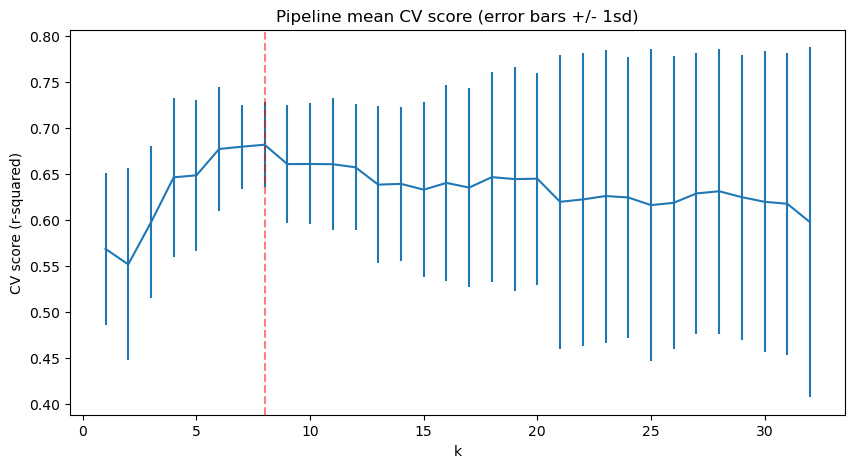

In [369]:
#Code task 20#
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
print(best_k)
plt.subplots(figsize=(10, 5))
# The errorbar function adds error bars that vertically and/or horizontally extend from each data point, 
# The function takes x and y coordinates as input, along with optional arguments to specify the error values in both directions. 
# It offers customization options for the appearance of the error bars, such as color, line width, and cap size.
# In this example, x = cv_k and y = score_mean defines the data points, and yerr specifies the error in the y-direction. 
plt.errorbar(cv_k, score_mean, yerr=score_std)
# The axvline function in Matplotlib adds a vertical line spanning the entire, or a fraction of, the y-axis of a plot. 
# It is commonly used to highlight specific x-values or regions of interest on a graph - in this case, the dotted line at k = 8 or best_k
# axvline takes the x-coordinate of the line as its primary argument.
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 8. There was an initial rapid increase with k, followed by a slow decline. Also noticeable is the variance of the results greatly increase above k=8. As you increasingly overfit, expect greater swings in performance as different points move in and out of the train/test folds.

Which features were most useful? Step into your best model, shown below. Starting with the fitted grid search object, you get the best estimator, then the named step 'selectkbest', for which you can its `get_support()` method for a logical mask of the features selected.

**lr_grid_cv.best_estimator_**: The best model (with optimal hyperparameters) found during the grid search.

**.named_steps.selectkbest**: Accesses the SelectKBest step within the scikit-learn pipeline. Assumes the pipeline has a step named 'selectkbest' (e.g., from Pipeline([('selectkbest', SelectKBest()), ...]).

**.get_support()**: Returns a boolean array where True means the feature was selected, and False means it was discarded. For example output: [True, False, True] → Features 0 and 2 were selected, feature 1 was dropped.

In [278]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
print(selected)
X_test.columns[selected]

[False  True False  True False  True False False False False  True  True
 False  True  True  True False False False False False False False False
 False False False False False False False False]


Index(['vertical_drop', 'trams', 'fastQuads', 'total_chairs', 'Runs',
       'LongestRun_mi', 'SkiableTerrain_ac', 'Snow Making_ac'],
      dtype='object')

Similarly, instead of using the 'selectkbest' named step, you can access the named step for the linear regression model and, from that, grab the model coefficients via its `coef_` attribute:

In [282]:
#Code task 21#
#Get the linear model coefficients from the `coef_` attribute of the GridSearch CV object and store in `coefs`,
#get the matching feature names from the column names of the training dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

vertical_drop        10.767857
Snow Making_ac        6.290074
total_chairs          5.794156
fastQuads             5.745626
Runs                  5.370555
LongestRun_mi         0.181814
trams                -4.142024
SkiableTerrain_ac    -5.249780
dtype: float64

These results suggest that vertical drop is your biggest positive feature. This makes intuitive sense and is consistent with what you saw during the EDA work. Also, you see the area covered by snow making equipment is a strong positive as well. People like guaranteed skiing! The skiable terrain area is negatively associated with ticket price! This seems odd. People will pay less for larger resorts? There could be all manner of reasons for this. It could be  an effect whereby larger resorts can host more visitors at any one time and so can charge less per ticket. As has been mentioned previously, the data are missing information about visitor numbers. Bear in mind,  the coefficient for skiable terrain is negative _for this model_. For example, if you kept the total number of chairs and fastQuads constant, but increased the skiable terrain extent, you might imagine the resort is worse off because the chairlift capacity is stretched thinner.

## 4.10 Random Forest Model<a id='4.10_Random_Forest_Model'></a>

A model that can work very well in a lot of cases is the random forest. For regression, this is provided by `sklearn`'s `RandomForestRegressor` class.

Time to stop the bad practice of repeatedly checking performance on the test split. Instead, go straight from defining the pipeline to assessing performance using cross-validation. `cross_validate` will perform the fitting as part of the process. This uses the default settings for the random forest so you'll then proceed to investigate some different hyperparameters.

### 4.10.1 Define the pipeline<a id='4.10.1_Define_the_pipeline'></a>

In [286]:
#Code task 22#
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

### 4.10.2 Fit and assess performance using cross-validation<a id='4.10.2_Fit_and_assess_performance_using_cross-validation'></a>

In [288]:
#Code task 23#
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [290]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.69249204, 0.78061953, 0.77546915, 0.62190924, 0.61742339])

In [292]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.6975826707112506, 0.07090742940774528)

### 4.10.3 Hyperparameter search using GridSearchCV<a id='4.10.3_Hyperparameter_search_using_GridSearchCV'></a>

Random forest has a number of hyperparameters that can be explored, however here you'll limit yourselves to exploring some different values for the number of trees. You'll try it with and without feature scaling, and try both the mean and median as strategies for imputing missing values.

In [295]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

The fine tuning is done by redefining the grid_params argument that will be passed into the GridSearchCV function later.
The grid_params dictionary defines hyperparameter options for GridSearchCV applied to a pipeline containing:

RandomForestRegressor - 'randomforestregressor__n_estimators': n_est
This refers to the number of trees in a RandomForestRegressor. The search will test different values from n_est.

StandardScaler - 'standardscaler': [StandardScaler(), None]
This helps us test whether StandardScaler() should be applied or not. None means the model will be trained without scaling.

SimpleImputer -'simpleimputer__strategy': ['mean', 'median']
Specifies different imputation strategies for handling missing values:
'mean': Replace missing values with the mean of the column.
'median': Replace missing values with the median of the column.

In [297]:
#Code task 24#
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [299]:
#Code task 25#
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [303]:
#Code task 26#
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 69,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

It looks like imputing with the median helps, but scaling the features doesn't.

**Grace's Question**: Based on what? What's this referring to in the above output???

**Answer**:

_The best_params_ attribute displays_ the best hyperparameters found during the hyperparameter tuning process.

_randomforestregressor__n_estimators_	69 : This means that the best-performing random forest uses 69 trees (instead of default 100).
simpleimputer__strategy	'median' : this means that in the best model, issing values are filled with the median of each column (not mean/mode).

_standardscaler_	None : this means that the StandardScaler step was disabled in the best configuration.

In [301]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.6951357 , 0.79430697, 0.77170917, 0.62254707, 0.66499334])

In [95]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.7097384501425082, 0.06451341966873386)

You've marginally improved upon the default CV results. Random forest has many more hyperparameters you could tune, but we won't dive into that here.

The **feature_importances_** attribute of rf_grid_cv.best_estimator_.named_steps.randomforestregressor represents the relative importance of each feature used by the best-tuned random forest model in your pipeline. 

1.  **Definition**: A numpy array where each value indicates the importance score of a feature (higher = more important). Scores are normalized to sum to 1 (or 100% importance across all features).

2. **How Importance is Calculated:** For random forests, importance is typically based on:
Gini Importance: How much a feature reduces impurity (variance) across all trees.
Mean Decrease in Impurity (MDI): Average reduction in MSE (for regression) or Gini index (for classification) caused by splits on the feature.

3. **Key Properties:**
Range: [0, 1] (e.g., [0.2, 0.8] means the second feature is 4× more important than the first).
Interpretability: Helps identify which features drive predictions.

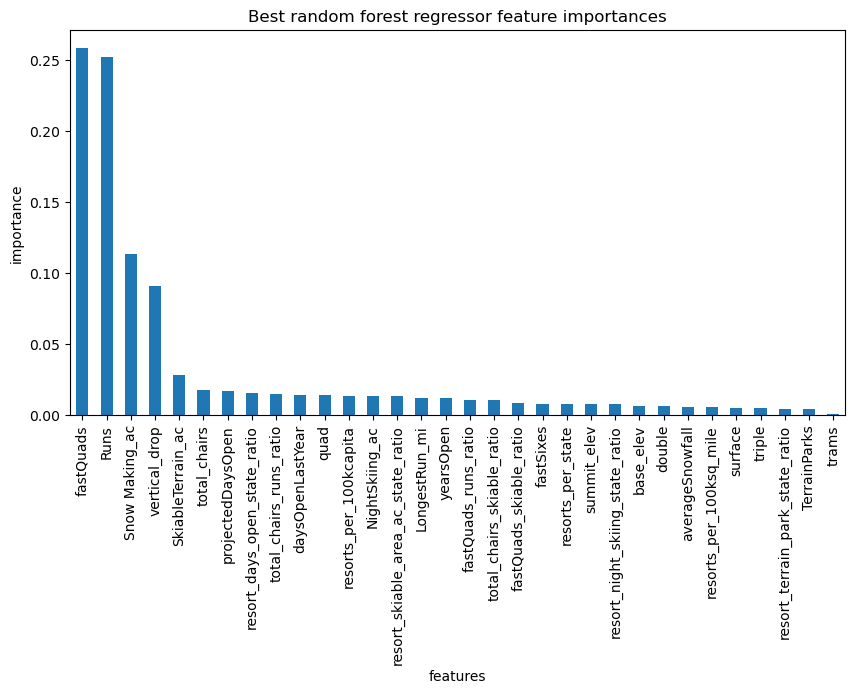

In [311]:
#Code task 27#
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

Encouragingly, the dominant top four features are in common with your linear model:
* fastQuads
* Runs
* Snow Making_ac
* vertical_drop

## 4.11 Final Model Selection<a id='4.11_Final_Model_Selection'></a>

Time to select your final model to use for further business modeling! It would be good to revisit the above model selection; there is undoubtedly more that could be done to explore possible hyperparameters.
It would also be worthwhile to investigate removing the least useful features. Gathering or calculating, and storing, features adds business cost and dependencies, so if features genuinely are not needed they should be removed.
Building a simpler model with fewer features can also have the advantage of being easier to sell (and/or explain) to stakeholders.
Certainly there seem to be four strong features here and so a model using only those would probably work well.
However, you want to explore some different scenarios where other features vary so keep the fuller 
model for now. 
The business is waiting for this model and you have something that you have confidence in to be much better than guessing with the average price.

Or, rather, you have two "somethings". You built a best linear model and a best random forest model. You need to finally choose between them. You can calculate the mean absolute error using cross-validation. Although `cross-validate` defaults to the $R^2$ [metric for scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring) regression, you can specify the mean absolute error as an alternative via
the `scoring` parameter.

### 4.11.1 Linear regression model performance<a id='4.11.1_Linear_regression_model_performance'></a>

In [316]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [318]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(10.499032338015294, 1.6220608976799682)

In [320]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

11.793465668669324

In [ ]:
# note that cross-validate only uses the X_train and y_train data to create the five folds. It doesn't use the X_test and y_test data.
# so the two scores are independent 

### 4.11.2 Random forest regression model performance<a id='4.11.2_Random_forest_regression_model_performance'></a>

In [322]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [324]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(9.644639167595688, 1.3528565172191818)

In [326]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

9.537730050637332

### 4.11.3 Conclusion<a id='4.11.3_Conclusion'></a>

The random forest model has a lower cross-validation mean absolute error by almost $1. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

Note that we choose the model with better performance on the test data and not the model with better performance on the cross-validation. Why?

## 4.12 Data quantity assessment<a id='4.12_Data_quantity_assessment'></a>

Finally, you need to advise the business whether it needs to undertake further data collection. **Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes.** The `learning_curve` function does this conveniently.

In [378]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(train_size)
print(len(X_train))

[ 30  38  46  53  61  69  77  92 115 123 154]
193


In [374]:
# train_scores: Scores (e.g., accuracy, R²) on the training subsets (shape: (n_train_sizes, n_cv_folds)).

test_scores: Scores on the validation subsets (cross-validation).pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x145169e40>)),
                ('linearregression', LinearRegression())])

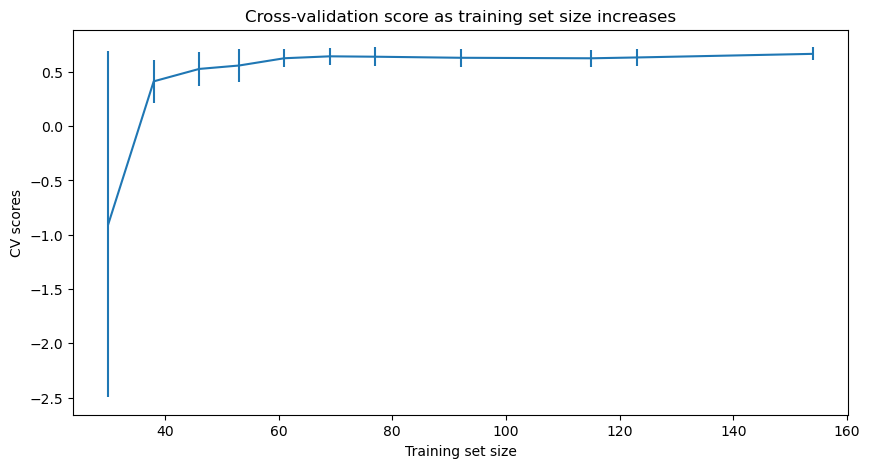

In [330]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 40-50.

## 4.13 Save best model object from pipeline<a id='4.13_Save_best_model_object_from_pipeline'></a>

In [333]:
#Code task 28#
#This may not be "production grade ML deployment" practice, but adding some basic
#information to your saved models can save your bacon in development.
#Just what version model have you just loaded to reuse? What version of `sklearn`
#created it? When did you make it?
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
#the numpy version (`np.__version__`) to the `numpy_version` attribute,
#the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
#and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
#Let's call this model version '1.0'
best_model = rf_grid_cv.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [335]:
# save the model

modelpath = '../models'
save_file(best_model, 'ski_resort_pricing_model.pkl', modelpath)

Directory ../models was created.
Writing file.  "../models/ski_resort_pricing_model.pkl"


## 4.14 Summary<a id='4.14_Summary'></a>

**Q: 1** Write a summary of the work in this notebook. Capture the fact that you gained a baseline idea of performance by simply taking the average price and how well that did. Then highlight that you built a linear model and the features that found. Comment on the estimate of its performance from cross-validation and whether its performance on the test split was consistent with this estimate. Also highlight that a random forest regressor was tried, what preprocessing steps were found to be best, and again what its estimated performance via cross-validation was and whether its performance on the test set was consistent with that. State which model you have decided to use going forwards and why. This summary should provide a quick overview for someone wanting to know quickly why the given model was chosen for the next part of the business problem to help guide important business decisions.

**A: 1** First, we performed a 70/30 train test split and removed Montana from our data. We then took the average price of the training data set and predict that as the ticket price value for each state ($63.8). This served as a naive or baseline model to compare subsequent models to. We also saw that this baseline model had a mean absolute error (MAE) of 19.14, suggesting you’d be off by about $19.14 if you simply predicted ticket prices in the test data based on the training set average.  

We then created a pipeline to compare different approaches to imputing, scaling, and building a linear predictive model more efficiently. To create a linear model, we first imputed missing values as the median of each feature and standardized all data points to have a mean of zero and a standard deviation of one. We then also told the pipeline to help us determine which features (Selectkbest) produce the best linear model. 

To optimize initial linear models, we passed the pipeline object described above into the GridSearchCV function which allowed us to cross_validate our model on five folds of the training data to avoid overfitting to one particular training data set. We simultaneously told the GridSearchCV function that we wanted to vary the number of features used in the linear model with the param_grid parameter. The resulting grid search cross-validation object (lr_grid_cv) allowed us to identify the best linear model C which included 8 features or variables from our training data. These features were the vertical change in elevation from the summit to the base, the total area covered by snow making machines, the total number of chairlifts, the number of fast four person chairs, the number of runs, the length of the longest run, the number of trams, and the total skiable area in order of largest positive coefficient to the smallest negative coefficient. 

We then created a new pipeline to use a random forest model instead of a linear model to see if we can further optimize our models ability to predict ticket prices. We tested different hyperparameters such as the number of trees in the random forest model, scaling or not scaling data, and different methods of imputing missing data. We passed those parameters into GridSearchCV, which we then fit to our training data again to produce our final random forest model. Results indicated that the best performing random forest used 69 trees, a median imputation method, and did not scale the data. The model also provides the relative importance of different features. The most important four features from most to least important were the number of fast four person chairs, the number of runs, the total area covered by snow making machines, and the vertical change in elevation from the summit to the base; these stuck out as being most influential in predicting price.

Finally, we compared the performance of the final random forest model and our linear model by calculating the MAE for both models using the cross_validate function across 5 folds and on the test data set. On cross validation, the random forest model  performed slightly better (MAE = 9.64, st dev 1.35) compared to the linear model  (10.50, st dev=1.62). Similarly, when applying the models to the test data, the random forest model (MAE = 9.64) outperformed the linear model  (MAE = 11.79) in its ability to predict ticket prices of the test data. 

Lastly, we used the learning_curve function to assess whether we needed more data to train linear model and found that model test scores began to level off around a training set size of 38 whereas our training data set had 193 values, so more observations on the variables contained in our data set won't give us significantly better estimates. 